(quickstart)=

In [1]:
try:
    import smolgp
except ImportError:
    %pip install -q smolgp
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

import jax
key = jax.random.PRNGKey(0)

# Quickstart Guide

The driving design philosophy of `smolgp` is to match the API of ``tinygp`` as closely as possible. With only a few exceptions, any existing code you have that uses ``tinygp`` should work with ``smolgp`` by simply by finding-and-replacing ``tiny`` with ``smol``. In this tutorial, we show the basic usage for constructing a GP object and using it to condition on data and make predictions.

:::{important}
By default, JAX only uses 32-bit floating point precision. For basically everything we want to do, we'll want [double (64-bit) precision](https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision) which you can enable like so:
:::

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

## Initializing the GP kernel

For this demonstration, we'll use a damped, driven harmonic oscillator (SHO) as our latent process. We'll build the model in both `smolgp` and `tinygp` to show their similarity and any differences.

In [3]:
import jax.numpy as jnp

sigma = 2.1           # oscillation amplitude
omega = 2*jnp.pi/60.  # oscillation frequency
quality = 5.3         # quality factor, < 0.5 for underdamped

kssm = smolgp.kernels.SHO(omega, quality, sigma)
kqsm = tinygp.kernels.quasisep.SHO(omega, quality, sigma)

### Covariance

We can plot the covariance function to show that the two are identical:

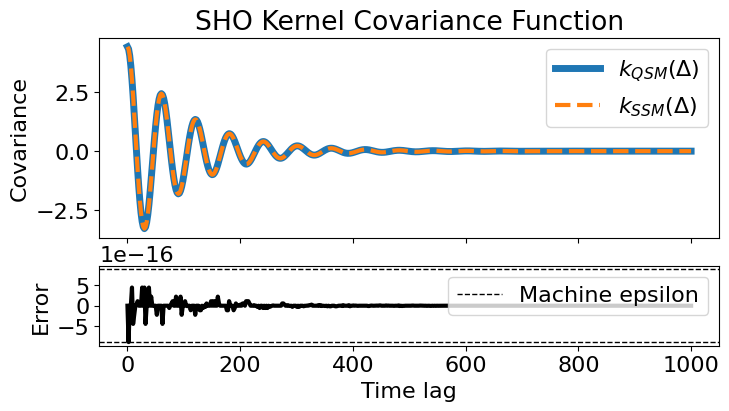

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font', family='sans serif', size=16)

dts = jnp.linspace(0, 1000, 500)
zeros = jnp.zeros_like(dts)

cov_qsm = kqsm(zeros, dts)[0,:]
cov_ssm = kssm(zeros, dts)[0,:]
res_cov = cov_ssm - cov_qsm

## Make the plot
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,4), sharex=True, gridspec_kw={'height_ratios': [3, 1.2]})

ax.plot(dts, cov_qsm, label=r'$k_{QSM}(\Delta)$', lw=5, color='C0')
ax.plot(dts, cov_ssm, label=r'$k_{SSM}(\Delta)$', lw=3, color='C1', ls='--')
ax.set(ylabel='Covariance', title=f'{kqsm.__class__.__name__} Kernel Covariance Function')
ax.legend()

rax.plot(dts, res_cov, lw=3, color='k')
rax.set(ylabel='Error', xlabel='Time lag')
eps = jnp.abs(jnp.spacing(cov_qsm))
rax.axhline(eps.max(),  color='k', ls='--', lw=1, label='Machine epsilon')
rax.axhline(-eps.max(), color='k', ls='--', lw=1);
rax.legend(loc='upper right');

### Power spectrum

We can also inspect the power spectral density (PSD) like so:

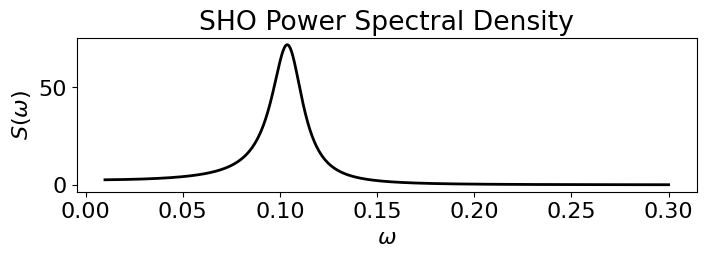

In [5]:
w = jnp.linspace(0.01, 0.3, 1000)
S = kssm.psd(w)

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(w, S, color='k', lw=2)
ax.set(title=f'{kssm.name} Power Spectral Density')
ax.set(xlabel=r'$\omega$', ylabel=r'$S(\omega)$');

## Sample data

To go further, we'll need some data to plot and condition the GP on. We can generate some by using the `sample` function of a `tinygp.GaussianProcess` (a state-space version of this is coming soon to `smolgp`):

In [6]:
from scipy.interpolate import make_smoothing_spline

def get_true_process(true_kernel, tmin=0, tmax=1000, dt=1):
    t = jnp.arange(tmin, tmax, dt)
    true_gp = tinygp.GaussianProcess(true_kernel, t)
    # NOTE: gp.sample adds small random noise for numerical stability
    y_sample = true_gp.sample(key=jax.random.PRNGKey(32)) 
    f = make_smoothing_spline(t, y_sample, lam=dt/6)
    return t, f

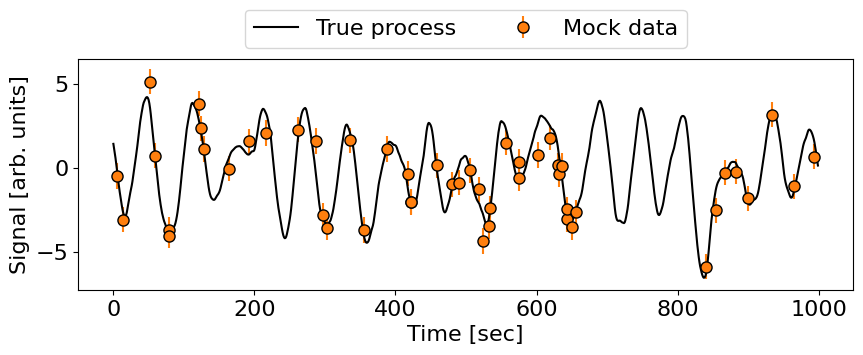

In [7]:
## True process
t_true, f = get_true_process(kqsm, tmin=0, tmax=1000, dt=1)
y_true = f(t_true)

## Mock data
t_train  = jnp.sort(jax.random.uniform(key, (50,), minval=0, maxval=1000))
yerr = 0.75 * jnp.ones_like(t_train)
y_train = f(t_train) + yerr * jax.random.normal(key, t_train.shape)

# Plot data and true process
fig, ax = plt.subplots(figsize=(10, 3))
ax.errorbar(t_train, y_train, yerr=yerr, fmt="o", color='C1', label='Mock data',
             markeredgecolor='k', markersize=8, capsize=0)
ax.plot(t_true, y_true, color='k', label="True process")
ax.set(xlabel='Time [sec]', ylabel='Signal [arb. units]')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=2);

## Constructing the GP object

Constructing the GP object is the same in `tinygp` and `smolgp`. The `GaussianProcess` object needs at minimum a `kernel` and the coordinates of the data `X` (which can be a tuple if the data have multiple identifiers, such as `X=(time, exposure_time, instrument_id)`). The data often come with measurement error which are passed to the `diag` argument as the variance.

In [8]:
gp_ssm = smolgp.GaussianProcess(kernel=kssm, X=t_train, diag=yerr**2)
gp_qsm = tinygp.GaussianProcess(kernel=kqsm, X=t_train, diag=yerr**2)

At the moment, setting a nonzero `mean` is not supported in `smolgp`, but in principle is a matter of bookkeeping to implement. Conversely, other `noise` models which are well-defined in the covariance framework in `tinygp` are not readily implemented in `smolgp`; only `diag` is presently supported.

## Likelihood

The call-signature to obtain the log-likelihood is the same in `smolgp` as in `tinygp`:

In [16]:
llh_ssm = gp_ssm.log_probability(y_train)
llh_qsm = gp_qsm.log_probability(y_train)

In [17]:
print('Log-likelihood:')
llh_diff = llh_ssm - llh_qsm
print(f"   smolgp: {llh_ssm:f}")
print(f"   tinygp: {llh_qsm:f}")
print(f"   Difference: {llh_diff:.3e}")
assert jnp.abs(llh_diff) < 1e-12, "Log-likelihoods do not match!"
print("Log-likelihoods match to numerical precision!")

Log-likelihood:
   smolgp: -95.934278
   tinygp: -95.934278
   Difference: 0.000e+00
Log-likelihoods match to numerical precision!


## Conditioning

Conditioning the GP on data is also the same syntax as `tinygp`, and likewise returns both the log-likelihood and the conditioned GP object. The conditioned mean and variance at the data are stored in this conditioned GP object in the `loc` and `variance` attributes.

In [18]:
llh_qsm2, condGP_qsm = gp_qsm.condition(y_train)
llh_ssm2, condGP_ssm = gp_ssm.condition(y_train)

In [ ]:
print('Conditioning GPs on data...')
assert llh_qsm2==llh_qsm, 'tinygp: Condition returned different llh than log_probability!'
assert llh_ssm2==llh_ssm, 'smolgp: Condition returned different llh than log_probability!'

mean_diff = condGP_qsm.loc - condGP_ssm.loc
offset = jnp.sqrt(jnp.finfo(jnp.array([0.])).eps) # tinygp includes a small jitter in variance for numerical stability
var_diff  = (condGP_qsm.variance-offset) - condGP_ssm.variance
print(f'   Mean max abs diff: {jnp.max(jnp.abs(mean_diff)):.3e}')
print(f'   Variance max abs diff: {jnp.max(jnp.abs(var_diff)):.3e}')
assert jnp.max(jnp.abs(mean_diff)) < 1e-9, "Conditioned means do not match!"
assert jnp.max(jnp.abs(var_diff)) < 1e-9, "Conditioned variances do not match!"
print('Conditioned means and variances match to numerical precision!')

Conditioning GPs on data...
   Mean max abs diff: 1.332e-15
   Variance max abs diff: 2.470e-15
Conditioned means and variances match to numerical precision!


## Predicting at arbitrary coordinates

The syntax for predicting at an array of test coordinates is slightly different. In `smolgp`, the first argument of `predict` is the test coordinate array rather than the data array. This is because the condition step has already incorporated the measurement values, and so the conditioned GP object can be used to do just the prediction step and save on computation. In `tinygp`, the `predict` function essentially conditions and predicts simultaneously, so both arrays are required and overall is slower to compute.

In [23]:
t_test = jnp.arange(-100, 1100, 1)
mu_qsm, var_qsm = gp_qsm.predict(y_train, t_test, return_var=True)
mu_ssm, var_ssm = condGP_ssm.predict(t_test, return_var=True)

In [24]:
print('\nPredictions at new points:')
pred_mean_diff = mu_qsm - mu_ssm
pred_var_diff  = (var_qsm - offset) - var_ssm
print(f'   Mean max abs diff: {jnp.max(jnp.abs(pred_mean_diff)):.3e}')
print(f'   Variance max abs diff: {jnp.max(jnp.abs(pred_var_diff)):.3e}')
assert jnp.max(jnp.abs(pred_mean_diff)) < 1e-9, "Predicted means do not match!"
assert jnp.max(jnp.abs(pred_var_diff)) < 1e-9, "Predicted variances do not match!"
print('Predicted means and variances match to numerical precision!')


Predictions at new points:
   Mean max abs diff: 7.105e-15
   Variance max abs diff: 4.274e-15
Predicted means and variances match to numerical precision!


It is possible of course in `smolgp` to condition and predict all in one step, like so:

In [25]:
mu_ssm2, var_ssm2 = gp_ssm.predict(t_test, y_train, return_var=True)
print(jnp.all(mu_ssm2==mu_ssm), jnp.all(var_ssm2==var_ssm))

True True


## Plotting the results

Below we plot the data, the true process, the predictions at the data points (and their residuals in the lower panel), as well as the predictive mean and variance before, during, and after the data.

In [26]:
import numpy as np

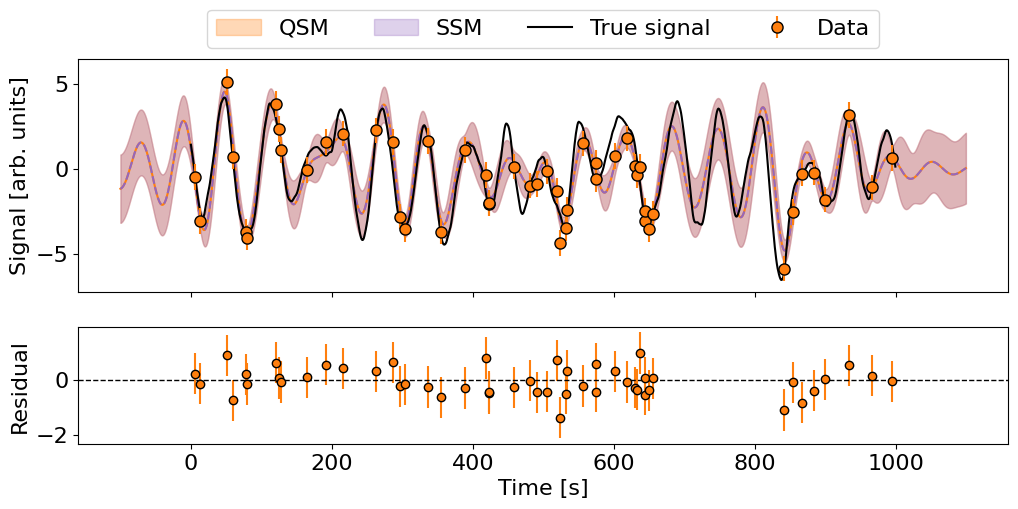

In [27]:
fig, (ax, rax) = plt.subplots(2,1, figsize=(12,5), sharex=True,
                                    gridspec_kw={'height_ratios':[2,1]})

## Predictions
ax.plot(t_test, mu_qsm, color='C1')
ax.plot(t_test, mu_ssm, color='C4', ls='--')
ax.fill_between(t_test, mu_qsm-jnp.sqrt(var_qsm), mu_qsm+jnp.sqrt(var_qsm), color='C1', alpha=0.3, label='QSM')
ax.fill_between(t_test, mu_ssm-jnp.sqrt(var_ssm), mu_ssm+jnp.sqrt(var_ssm), color='C4', alpha=0.3, label='SSM')
ax.set(ylabel='Signal [arb. units]')

## Data and true signal
ax.plot(t_true, y_true, label='True signal', color='k', lw=1.5)
ax.errorbar(t_train, y_train, yerr, fmt='o', color='C1', markeredgecolor='k', markersize=8, label='Data', alpha=1)
ax.legend(bbox_to_anchor=(0.5, 1), loc='lower center', ncol=4)

## Residuals
rax.errorbar(t_train, y_train - condGP_ssm.loc, yerr, fmt='o', color='C1', markeredgecolor='k', label='Data', alpha=1)
rax.axhline(0, color='k', ls='--', lw=1)
rax.set(xlabel='Time [s]', ylabel='Residual');

We can also verify that the conditioned and predictive results are the same between `smolgp` and `tinygp` to within machine precision.

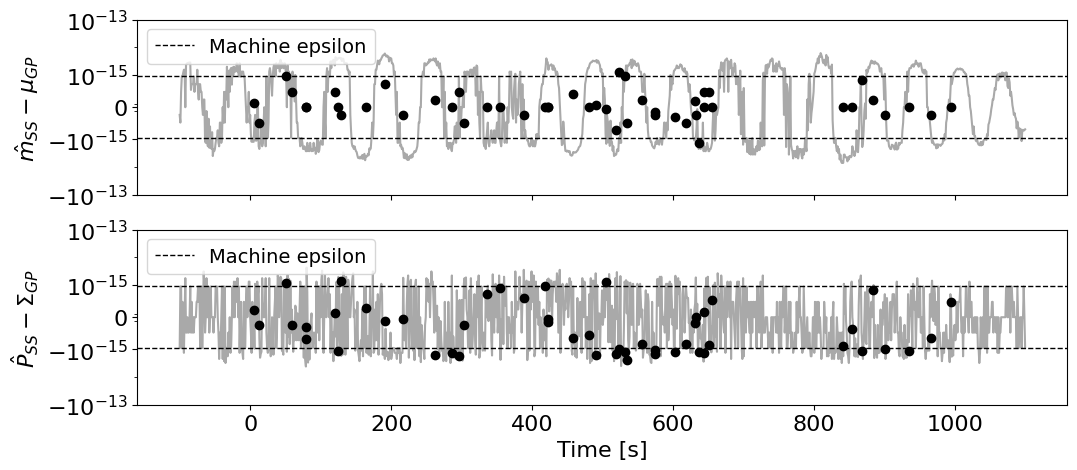

In [28]:
fig, (max, vax) = plt.subplots(2,1, figsize=(12,5), sharex=True,)

## Mean residuals
max.scatter(t_train, mean_diff, color='k', zorder=100)
max.plot(t_test, pred_mean_diff, color='darkgrey')
eps = np.abs(np.spacing(mu_ssm))
epsmax = eps.max()
max.axhline(epsmax,  color='k', ls='--', lw=1, label='Machine epsilon')
max.axhline(-epsmax, color='k', ls='--', lw=1)
max.set(ylabel=r'$\hat{m}_{SS}- \mu_{GP}$')
max.set_yscale('symlog', linthresh=epsmax)
yticks = jnp.arange(-15, -12+1, 2).astype(jnp.float64)
yticks = jnp.hstack((-10**yticks[::-1], 0, 10**yticks))
max.set_yticks(yticks)
max.legend(loc='upper left', fontsize=14)

## Var residuals
vax.scatter(t_train, var_diff, color='k', zorder=100)
vax.plot(t_test, pred_var_diff, color='darkgrey')
eps = np.abs(np.spacing(var_ssm))
epsmax = eps.max()
vax.axhline(epsmax,  color='k', ls='--', lw=1, label='Machine epsilon')
vax.axhline(-epsmax, color='k', ls='--', lw=1)
vax.set(ylabel=r'$\hat{P}_{SS}- \Sigma_{GP}$')
vax.set_yscale('symlog', linthresh=epsmax)
yticks = jnp.arange(-15, -12+1, 2).astype(jnp.float64)
yticks = jnp.hstack((-10**yticks[::-1], 0, 10**yticks))
vax.set_yticks(yticks)
vax.set_xlabel('Time [s]')
vax.legend(loc='upper left', fontsize=14);